## Brain Tumor Classification - Image Segmentation

Ayesha Aziz
<br> DS5500 - Capstone: Applications in Data Science
<br> Phase 1 Project

**Import Data Libraries**

In [54]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from albumentations import (Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, 
HorizontalFlip, Rotate)
import cv2
import seaborn as sb
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

#/Users/ayesha/opt/anaconda3/pkgs/graphviz-2.40.1-hefbbd9a_2

### Helper Functions

1. *Load Dataset*

In [3]:
def load_dataset(file_path):
    """
    Load images from all tumor sub-folders from training/test folders
    :param file_path: path to the training/test folder
    :return:
        image_data: numpy array with scan_image RGB pixel data
        image_labels: numpy array with class labels for images
    """
    image_data = []
    image_classes = []

    # go over each tumor sub-folder
    for tumor_type in os.listdir(file_path):
        # read each scan_image file within the folder
        for img_file in os.listdir(os.path.join(file_path, tumor_type)):
            image_path = os.path.join(file_path, tumor_type, img_file)

            # convert BGR format to RGB
            scan_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)

            # resize images to the same size, set by IMAGE_DIM
            scan_image = cv2.resize(scan_image, (IMAGE_DIM, IMAGE_DIM), interpolation=INTERPOLATION_)

            # convert image data into a numpy array of float32 data type
            scan_image = np.array(scan_image)
            scan_image = scan_image.astype('float32')

            # normalize the pixel values between 0-1
            scan_image /= 255

            # add pixel information to image data list
            image_data.append(scan_image)

            # add image label to the label list
            image_classes.append(tumor_type)

    return np.array(image_data), np.array(image_classes)

2. *Plot MRI scans*

In [4]:
def plot_image(file_path):
    """
    Plot 5 random MRI scans from a given folder
    :param file_path: path to the folder
    :return: subplots of scans
    """
    plt.figure(figsize=(20, 5))
    for i in range(5):
        file = random.choice(os.listdir(file_path))
        img_path = os.path.join(file_path, file)
        img = mpimg.imread(img_path)
        ax = plt.subplot(1, 5, i + 1)
        title = os.path.basename(os.path.normpath(file_path))
        ax.title.set_text(title)
        plt.imshow(img)
    plt.show()


3. *One-Hot-Encoding of labels*

In [5]:
def one_hot_encoding(class_names, y_data, binary=False):
    """
    convert y-label data into numerical encoding
    :type binary: bool
    :param class_names: class (tumor) names
    :param y_data: y_label data
    :param binary: if true, the encoding would be 0/1, if false, it would result in multiclass encoding
    :return: one-hot-encoded y-labels
    """
    # if binary classification has to be performed
    if binary:
        class_names = ['tumor' if label != "no_tumor" else label for label in class_names]
        y_data = ['tumor' if label != "no_tumor" else label for label in y_data]

    # replace image labels with respective class index
    indexed_y_data = []
    for img in y_data:
        indexed_y_data.append(class_names.index(img))

    y_data = to_categorical(indexed_y_data)

    return np.array(y_data)

#### Load Training and Test Data

In [6]:
# Hyperparameters - Binary Classification

IMG_ROTATION = 5
FLIP_IMG = True
IMG_ZOOM = 0.1
IMG_HEIGHT_SHIFT = 0.1
IMG_WIDTH_SHIFT = 0.1
BRIGHTNESS=[0.2,1.2]
IMAGE_DIM = 224
INTERPOLATION_ = cv2.INTER_AREA
VALIDATION_SIZE = 0.1


BATCH_SIZE = 64
EPOCHS = 5
LOSS = 'binary_crossentropy'

In [7]:
# load Training and Test data

X_train, y_train = load_dataset('data/Training')
X_test, y_test = load_dataset('data/Testing')

# create a list of class names
labels = set(y_train)
labels = list(labels)

#### Exploratory Data Analysis

In [8]:
print('Size of training data:', len(X_train))
print('Size of test data:', len(X_test))
print('Training data shape:', X_train.shape)
print('Class names in the dataset:')
print(labels)

Size of training data: 2870
Size of test data: 394
Training data shape: (2870, 224, 224, 3)
Class names in the dataset:
['glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor']


#### Plot the counts of labels in Test and Train data, and display MRI scans

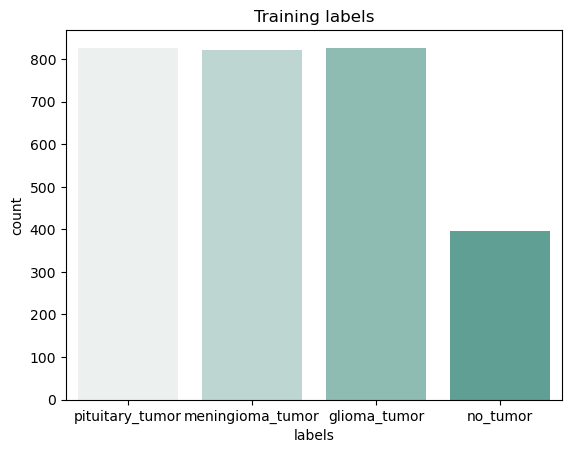

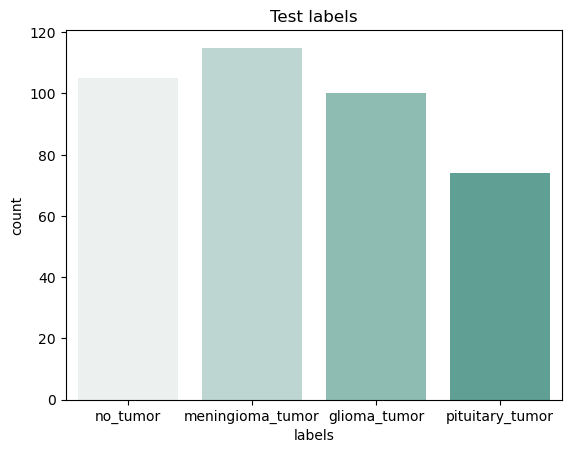

In [36]:
# plot tumor counts
sb.countplot(data=pd.DataFrame(y_train, columns=['labels']), x = 'labels', palette="light:#5A9").set(title='Training labels')
plt.show()
sb.countplot(data=pd.DataFrame(y_test, columns=['labels']), x = 'labels', palette="light:#5A9").set(title='Test labels')
plt.show()

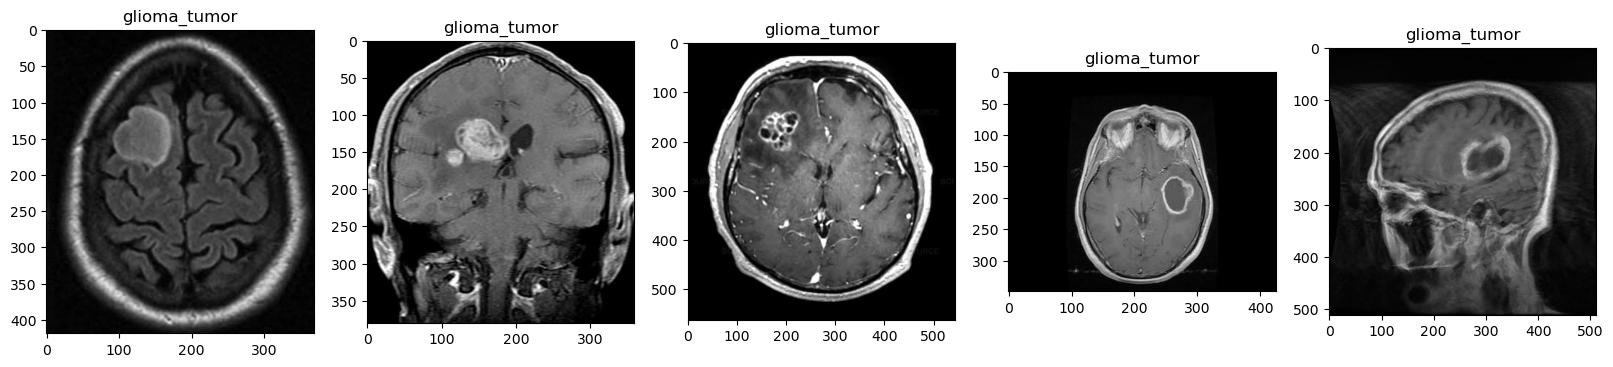

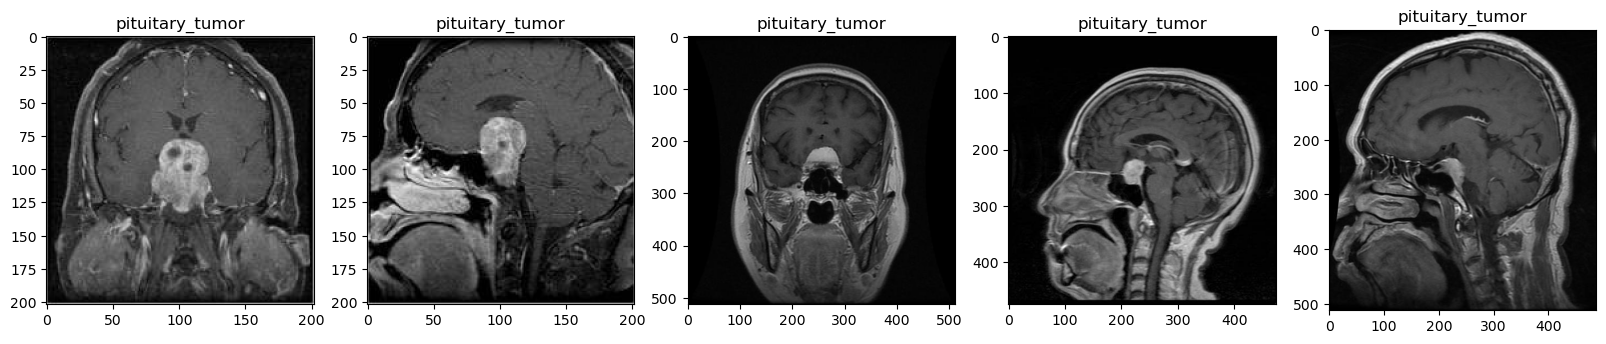

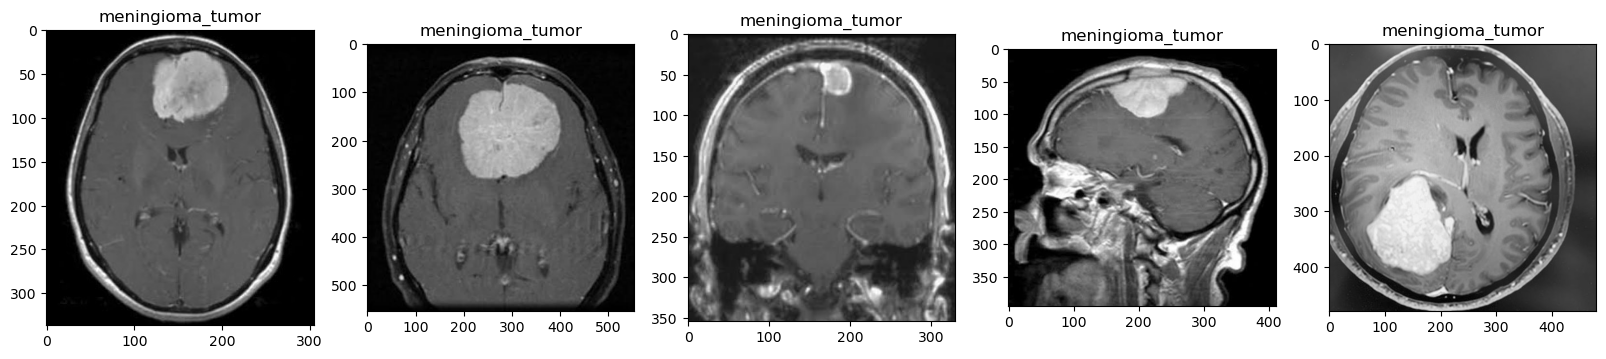

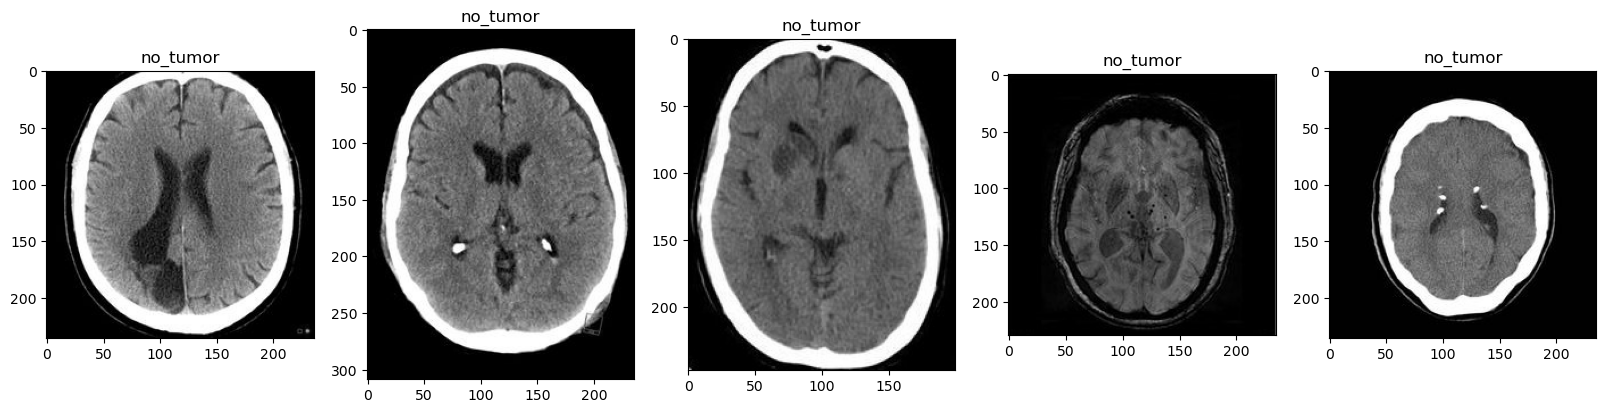

In [71]:
# Plot 5 random MRI scans for tumor/no tumor data
plot_image('data/Testing/glioma_tumor')
plot_image('data/Testing/pituitary_tumor')
plot_image('data/Testing/meningioma_tumor')
plot_image('data/Testing/no_tumor')

Shuffle, one-hot-encode and split the dataset 

In [9]:
# shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=0)

# convert y_train and y_test into one-hot-encoded data
y_train = one_hot_encoding(labels, y_train, binary=True)
y_test = one_hot_encoding(labels, y_test, binary=True)

# split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=0)

In [64]:
X_train.shape, X_val.shape, X_test.shape

((1000, 224, 224, 3), (287, 224, 224, 3), (394, 224, 224, 3))

In [46]:
# Take subsample of the dataset

X_train = X_train[:1000]
y_train = y_train[:1000]


### Model Building - Binary Classification

#### Data Augmentation

In [47]:
data_augmentation = ImageDataGenerator(
    # randomly rotate images in the range 0-180
    rotation_range=IMG_ROTATION,
    # randomly enlarge images
    zoom_range=IMG_ZOOM,
    # randomly shift images horizontally
    width_shift_range=IMG_WIDTH_SHIFT,
    # randomly shift images vertically
    height_shift_range=IMG_HEIGHT_SHIFT,
    # randomly flip images vertically
    vertical_flip=FLIP_IMG,
    # brightness range
    brightness_range=BRIGHTNESS)


Checkpoints during training of models

In [48]:
# stop if no improvements made after 3 epopchs (patience) and save the best model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# for possible visualization
tensorboard = TensorBoard(log_dir='logs')

# save the best model
checkpoint = ModelCheckpoint("cnn_layer1.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

#### Model 1: CNN with Single Layer 

Specifications:

    - No data augmentation
    - Sample size: 1000 training samples, 287 validation samples, 
    - Loss function: Binary cross-entropy
    - Evaluation Metric: Accuracy
    - Optimizer: Adam
    - Epochs: 5
    - Batch Size: 64

In [49]:
cnn1 = Sequential()
cnn1.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(IMAGE_DIM, IMAGE_DIM, 3)))
cnn1.add(Activation('relu'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
# cnn1.add(Dropout(0.35))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(2, activation='sigmoid'))


cnn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_4 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 802816)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               102760576 
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

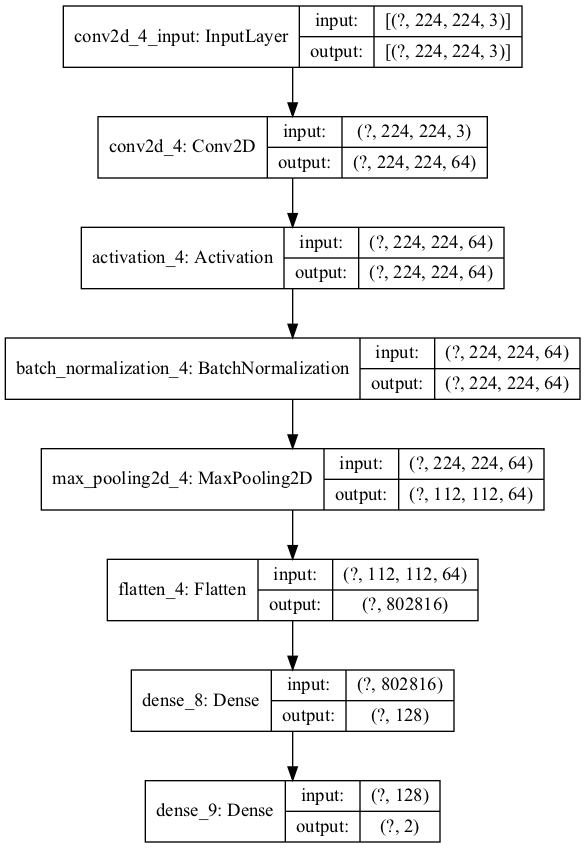

In [50]:
plot_model(
    cnn1,
    to_file="cnn1.png",
    show_shapes=True,
    show_layer_names=True
)

In [51]:
cnn1.compile(optimizer='adam',
             loss=LOSS,
             metrics=['accuracy'])

In [52]:
model1 = cnn1.fit(X_train, y_train, 
                         verbose=1, 
                         validation_data=(X_val, y_val),
                         epochs=EPOCHS,
                         callbacks=[early_stopping, checkpoint, tensorboard],
                         batch_size=BATCH_SIZE)

Train on 1000 samples, validate on 287 samples
Epoch 1/5
 960/1000 [===========================>..] - ETA: 7s - loss: 20.0073 - accuracy: 0.7708 
Epoch 00001: val_accuracy improved from -inf to 0.54704, saving model to cnn_layer1.h5
1000/1000 [==============================] - 198s 198ms/sample - loss: 19.4445 - accuracy: 0.7700 - val_loss: 0.8029 - val_accuracy: 0.5470
Epoch 2/5
 960/1000 [===========================>..] - ETA: 5s - loss: 0.7098 - accuracy: 0.8813 
Epoch 00002: val_accuracy improved from 0.54704 to 0.85888, saving model to cnn_layer1.h5
1000/1000 [==============================] - 156s 156ms/sample - loss: 0.6865 - accuracy: 0.8830 - val_loss: 0.6854 - val_accuracy: 0.8589
Epoch 3/5
 960/1000 [===========================>..] - ETA: 4s - loss: 0.1621 - accuracy: 0.8901 
Epoch 00003: val_accuracy improved from 0.85888 to 0.89895, saving model to cnn_layer1.h5
1000/1000 [==============================] - 130s 130ms/sample - loss: 0.1617 - accuracy: 0.8895 - val_loss: 0.6

AttributeError: 'History' object has no attribute 'save'

In [60]:
cnn1.save('cnn1_model1.h5')

In [59]:
loss1, accuracy1 = cnn1.evaluate(X_test, y_test)
print('Test loss and accuracy: ', loss1, accuracy1)

394/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss and accuracy:  0.665716630553231 0.4314721


In [69]:
print('Test loss and accuracy: ', loss1, accuracy1)

Test loss and accuracy:  0.665716630553231 0.4314721


#### Model 2: CNN with Single Layer

Specifications:

    - Data augmentation 
    - Binary cross-entropy used as the loss function
    - Accuracy used as the metric
    - batch size: 35
    - Optimizer: Adam

In [65]:
model2 = cnn1.fit_generator(data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
                            epochs=EPOCHS,
                            validation_data=(X_val, y_val),
                            
                            callbacks=[early_stopping, checkpoint, tensorboard])

#steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
#validation_steps=X_val.shape[0]//BATCH_SIZE,

Epoch 1/5
15/16 [===========================>..] - ETA: 32s - loss: 0.8648 - accuracy: 0.7650 
Epoch 00001: val_accuracy did not improve from 0.89895
16/16 [==============================] - 562s 35s/step - loss: 0.8439 - accuracy: 0.7665 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
15/16 [===========================>..] - ETA: 43s - loss: 0.8802 - accuracy: 0.7585 
Epoch 00002: val_accuracy did not improve from 0.89895
16/16 [==============================] - 747s 47s/step - loss: 0.8740 - accuracy: 0.7670 - val_loss: 1.6945 - val_accuracy: 0.8920
Epoch 3/5
15/16 [===========================>..] - ETA: 34s - loss: 0.7537 - accuracy: 0.9049 
Epoch 00003: val_accuracy did not improve from 0.89895
16/16 [==============================] - 573s 36s/step - loss: 0.7531 - accuracy: 0.9050 - val_loss: 1.6945 - val_accuracy: 0.8920
Epoch 4/5
15/16 [===========================>..] - ETA: 27s - loss: 0.8313 - accuracy: 0.8910
Epoch 00004: val_accuracy did not improve from 0.89895
16/16 [=

In [67]:
cnn1.save('cnn1_model.h5')

loss2, accuracy2 = cnn1.evaluate(X_test, y_test)


394/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss and accuracy:  76.989062004283 0.73350257


In [68]:
print('Test loss and accuracy - Model 2: ', loss2, accuracy2)

Test loss and accuracy - Model 2:  76.989062004283 0.73350257
